# Assignment 4: Block Matching and Harris Corner Detection
## Ex. 4.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "racecar" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

start
image_width 640
image_height 480
image_width 640
image_height 360
1.8939359267734552


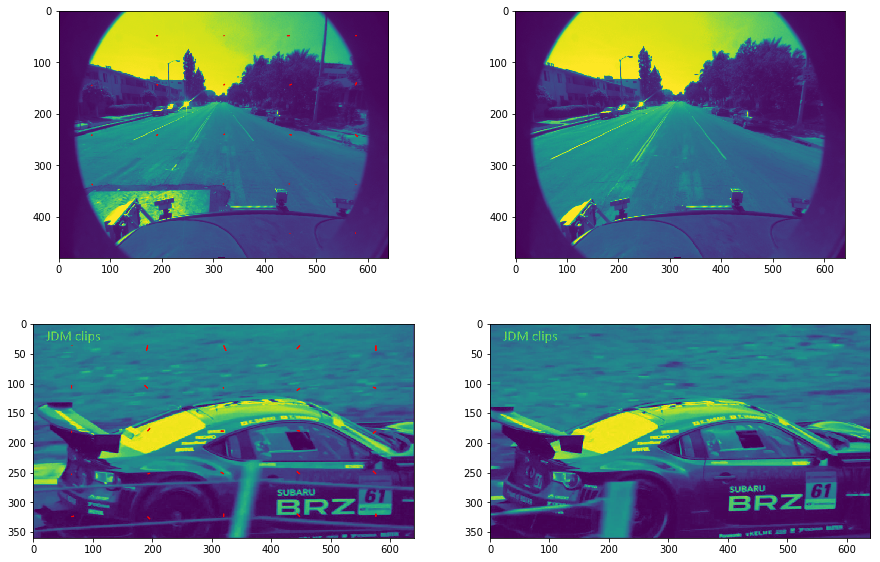

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, data, feature, color
import numpy as np
import math

def findMatch(block, blockLeft, newImage):
    # for lane, 50px neighbourhood
    neighbourhood = 5
    blockWidth = block.shape[1]
    blockHeight = block.shape[0]
    blockCenter = (blockLeft[0] + int(round(blockWidth/2)), 
                   blockLeft[1] + int(round(blockHeight/2)))
    
    minDif = math.inf
    match =  blockCenter
    
    neighbourhoodStartX = max(0, blockLeft[0] -  neighbourhood)
    neighbourhoodStartY = max(0, blockLeft[1] -  neighbourhood)
    
    for x in range(neighbourhood+neighbourhood):
        for y in range(neighbourhood+neighbourhood): # todo Bild cap
            ##oberer Rand, unterer Rand, linkerRand, rechter Rand
            currentNewLeft = (neighbourhoodStartX+x, neighbourhoodStartY+y)        
            currentNewBlock = newImage[currentNewLeft[1]:currentNewLeft[1]+blockHeight,
                                       currentNewLeft[0]: currentNewLeft[0]+blockWidth]
            
            # x Richtung, axis 1 
            padding_x = block.shape[1] - currentNewBlock.shape[1]
            # y Richtung, axis 0 
            padding_y = block.shape[0] - currentNewBlock.shape[0]  
            
            
            currentNewBlock = np.pad(currentNewBlock, ((0,padding_y), (0,padding_x)), 'constant')
            #try:
            newDiff = np.sum((block-currentNewBlock)**2)
            
            #newDiff = sumSquaredDiff(block, currentNewBlock)
            if newDiff < minDif:
                minDif = newDiff
                currentNewCenter = (currentNewLeft[0] + int(round(blockWidth/2)), 
                                    currentNewLeft[1] + int(round(blockHeight/2)))
                match = currentNewCenter
    
    return match

def blockMatching(oldImage, newImage, out=plt):
    image_width = oldImage.shape[1]
    countBlocksX = 5
    blockSizeX = int(math.floor(image_width/countBlocksX))

    image_height = oldImage.shape[0]
    countBlocksY = 5
    blockSizeY = int(math.floor(image_height/countBlocksY))
    print("image_width", image_width)
    print("image_height", image_height)

    for currentBlockX in range(countBlocksX):
        x = currentBlockX * blockSizeX
        for currentBlockY in range(countBlocksY): 
            y = currentBlockY * blockSizeY
            block = oldImage[y:y+blockSizeY, x:x+blockSizeX] #oberer Rand, unterer Rand, linkerRand, rechter Rand
            centerOldX, centerOldY = (x+blockSizeX//2, y+blockSizeY//2)
            centerOfMatchX, centerOfMatchY = findMatch(block, (x, y), newImage)
            dx, dy = (centerOfMatchX-centerOldX, centerOfMatchY - centerOldY)
            out.add_patch(
                patches.Arrow(centerOldX, centerOldY, dx, dy, edgecolor="red")
            )
            
def m():

    # chose other images if you like
    lane1 = io.imread('images/lane_detection/f00000.png')
    lane2 = io.imread('images/lane_detection/f00001.png')

    car1 = io.imread('images/racecar/100.jpeg')
    car2 = io.imread('images/racecar/102.jpeg') 

    fig = plt.figure(figsize=(15, 10))
    ax11 = plt.subplot(2, 2, 1)
    ax12 = plt.subplot(2, 2, 2)
    ax21 = plt.subplot(2, 2, 3)
    ax22 = plt.subplot(2, 2, 4)
    print("start")

    lane1 = color.rgb2gray(lane1)
    lane2 = color.rgb2gray(lane2)


    blockMatching(lane1, lane2, ax11)
    
    car1 = color.rgb2gray(car1)
    car2 = color.rgb2gray(car2)

    blockMatching(car1, car2, ax21)

    ax11.imshow(lane1)
    ax12.imshow(lane2)

    ax21.imshow(car1)
    ax22.imshow(car2)
    
if __name__ == '__main__':
    import timeit
    print(timeit.timeit("m()", setup="from __main__ import m", number=1))

## Ex. 4.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

In [16]:
import cv2
def calculateGradients(imgGrey):
    gradients = np.zeros((imgGrey.shape[0], imgGrey.shape[1], 2)) 
    for h in range(1, imgGrey.shape[0]-1):
        for w in range(1, imgGrey.shape[1]-1):
            gradients[h][w][0] = (imgGrey[h][w+1] - imgGrey[h] [w-1])/2
            gradients[h][w][1] = (imgGrey[h-1][w] - imgGrey[h+1][w])/2
    
    return gradients
                
def findCorners(image):
    imgGrey = color.rgb2gray(image)
    gradientX, gradientY =  np.gradient(imgGrey)
    k = 0.05 # 0.04 - 0.06
    gradientX_2 = gradientX*gradientX
    gradientY_2 = gradientY*gradientY
    gradientYX  = gradientX*gradientY
    detector =  gradientX_2*gradientY_2 - \
                gradientYX*gradientYX - \
                k * (gradientX_2 + gradientY_2)
            
    threshold = -0.0015 # 0.0015
    detectorMask = detector < threshold
    corners = np.zeros(image.shape, dtype=np.uint8)
    corners[detectorMask] = [255,255,255]
    #plt.imshow(corners)
       
    cornerList = []
    for y in range(detectorMask.shape[0]):
        for x in range(detectorMask.shape[1]):
            if detectorMask[y][x]: 
                point = [np.array([x, y], dtype=np.float32)]
                cornerList.append(np.array(point))
    cornerList = np.array(cornerList)
    return cornerList
    

def trackLane():
    lane1 = io.imread('images/lane_detection/f00000.png')
    lane1Grey = color.rgb2gray(lane1)
    
    """    feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

    p0 = cv2.goodFeaturesToTrack(lane1Grey, mask = None, **feature_params)"""
    
    corners = findCorners(lane1)
    #print(corners)
    lane2 = io.imread('images/lane_detection/f00001.png')
    lane2Grey = color.rgb2gray(lane2)

    lane1Grey = np.uint8(lane1Grey)
    lane2Grey = np.uint8(lane2Grey)

    nextPoints = np.empty_like(corners)
    #status = np.empty_like(corners)
    #print(corners.shape)'''
    
    
    lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    cv2.calcOpticalFlowPyrLK(lane1Grey, lane1Grey, corners, nextPoints, **lk_params)#, None,status, maxLevel=0
    #p1, st, err = 
    #mask = np.zeros_like(lane1Grey)
    #good_new = p1[st==1]
    #good_old = corners[st==1]
    
    for old,new in zip(corners,nextPoints):
        print("old", old)
        print("new", new)
        
    print(st)
    
    #for point in range(countBlocksX):
    '''x = currentBlockX * blockSizeX
    for currentBlockY in range(countBlocksY): 
        y = currentBlockY * blockSizeY
        block = oldImage[y:y+blockSizeY, x:x+blockSizeX] #oberer Rand, unterer Rand, linkerRand, rechter Rand
        centerOldX, centerOldY = (x+blockSizeX//2, y+blockSizeY//2)
        centerOfMatchX, centerOfMatchY = findMatch(block, (x, y), newImage)
        dx, dy = (centerOfMatchX-centerOldX, centerOfMatchY - centerOldY)
        out.add_patch(
            patches.Arrow(centerOldX, centerOldY, dx, dy, edgecolor="red")
        )'''

    '''# draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        lane1Grey = cv2.circle(lane1Grey,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(lane1Grey,mask)

    cv2.imshow('frame',lane1Grey)'''

    
if __name__ == '__main__':
    import timeit
    print(timeit.timeit("trackLane()", setup="from __main__ import trackLane", number=1))


old [[515.  19.]]
new [[515.  19.]]
old [[515.  20.]]
new [[515.  20.]]
old [[515.  21.]]
new [[515.  21.]]
old [[515.  22.]]
new [[515.  22.]]
old [[515.  23.]]
new [[515.  23.]]
old [[515.  24.]]
new [[515.  24.]]
old [[515.  25.]]
new [[515.  25.]]
old [[519.  25.]]
new [[519.  25.]]
old [[515.  26.]]
new [[515.  26.]]
old [[519.  26.]]
new [[519.  26.]]
old [[515.  27.]]
new [[515.  27.]]
old [[519.  27.]]
new [[519.  27.]]
old [[515.  28.]]
new [[515.  28.]]
old [[519.  28.]]
new [[519.  28.]]
old [[515.  29.]]
new [[515.  29.]]
old [[519.  29.]]
new [[519.  29.]]
old [[519.  30.]]
new [[519.  30.]]
old [[519.  31.]]
new [[519.  31.]]
old [[519.  32.]]
new [[519.  32.]]
old [[519.  33.]]
new [[519.  33.]]
old [[515.  34.]]
new [[515.  34.]]
old [[519.  34.]]
new [[519.  34.]]
old [[519.  35.]]
new [[519.  35.]]
old [[519.  36.]]
new [[519.  36.]]
old [[519.  37.]]
new [[519.  37.]]
old [[514.  38.]]
new [[514.  38.]]
old [[518.  38.]]
new [[518.  38.]]
old [[519.  38.]]
new [[519.

new [[420.  87.]]
old [[428.  87.]]
new [[428.  87.]]
old [[431.  87.]]
new [[431.  87.]]
old [[432.  87.]]
new [[432.  87.]]
old [[433.  87.]]
new [[433.  87.]]
old [[435.  87.]]
new [[435.  87.]]
old [[441.  87.]]
new [[441.  87.]]
old [[509.  87.]]
new [[509.  87.]]
old [[514.  87.]]
new [[514.  87.]]
old [[515.  87.]]
new [[515.  87.]]
old [[243.  88.]]
new [[243.  88.]]
old [[244.  88.]]
new [[244.  88.]]
old [[257.  88.]]
new [[257.  88.]]
old [[258.  88.]]
new [[258.  88.]]
old [[378.  88.]]
new [[378.  88.]]
old [[379.  88.]]
new [[379.  88.]]
old [[382.  88.]]
new [[382.  88.]]
old [[390.  88.]]
new [[390.  88.]]
old [[391.  88.]]
new [[391.  88.]]
old [[392.  88.]]
new [[392.  88.]]
old [[395.  88.]]
new [[395.  88.]]
old [[396.  88.]]
new [[396.  88.]]
old [[420.  88.]]
new [[420.  88.]]
old [[431.  88.]]
new [[431.  88.]]
old [[435.  88.]]
new [[435.  88.]]
old [[442.  88.]]
new [[442.  88.]]
old [[509.  88.]]
new [[509.  88.]]
old [[514.  88.]]
new [[514.  88.]]
old [[243.

old [[231. 100.]]
new [[231. 100.]]
old [[232. 100.]]
new [[232. 100.]]
old [[233. 100.]]
new [[233. 100.]]
old [[239. 100.]]
new [[239. 100.]]
old [[240. 100.]]
new [[240. 100.]]
old [[241. 100.]]
new [[241. 100.]]
old [[242. 100.]]
new [[242. 100.]]
old [[243. 100.]]
new [[243. 100.]]
old [[247. 100.]]
new [[247. 100.]]
old [[249. 100.]]
new [[249. 100.]]
old [[264. 100.]]
new [[264. 100.]]
old [[265. 100.]]
new [[265. 100.]]
old [[378. 100.]]
new [[378. 100.]]
old [[379. 100.]]
new [[379. 100.]]
old [[407. 100.]]
new [[407. 100.]]
old [[409. 100.]]
new [[409. 100.]]
old [[ 59. 101.]]
new [[ 59. 101.]]
old [[239. 101.]]
new [[239. 101.]]
old [[240. 101.]]
new [[240. 101.]]
old [[241. 101.]]
new [[241. 101.]]
old [[242. 101.]]
new [[242. 101.]]
old [[248. 101.]]
new [[248. 101.]]
old [[264. 101.]]
new [[264. 101.]]
old [[265. 101.]]
new [[265. 101.]]
old [[379. 101.]]
new [[379. 101.]]
old [[405. 101.]]
new [[405. 101.]]
old [[406. 101.]]
new [[406. 101.]]
old [[409. 101.]]
new [[409.

old [[ 83. 110.]]
new [[ 83. 110.]]
old [[ 84. 110.]]
new [[ 84. 110.]]
old [[ 85. 110.]]
new [[ 85. 110.]]
old [[ 86. 110.]]
new [[ 86. 110.]]
old [[ 87. 110.]]
new [[ 87. 110.]]
old [[ 88. 110.]]
new [[ 88. 110.]]
old [[ 90. 110.]]
new [[ 90. 110.]]
old [[ 91. 110.]]
new [[ 91. 110.]]
old [[ 94. 110.]]
new [[ 94. 110.]]
old [[ 95. 110.]]
new [[ 95. 110.]]
old [[100. 110.]]
new [[100. 110.]]
old [[101. 110.]]
new [[101. 110.]]
old [[210. 110.]]
new [[210. 110.]]
old [[211. 110.]]
new [[211. 110.]]
old [[212. 110.]]
new [[212. 110.]]
old [[213. 110.]]
new [[213. 110.]]
old [[240. 110.]]
new [[240. 110.]]
old [[241. 110.]]
new [[241. 110.]]
old [[242. 110.]]
new [[242. 110.]]
old [[246. 110.]]
new [[246. 110.]]
old [[247. 110.]]
new [[247. 110.]]
old [[248. 110.]]
new [[248. 110.]]
old [[250. 110.]]
new [[250. 110.]]
old [[263. 110.]]
new [[263. 110.]]
old [[264. 110.]]
new [[264. 110.]]
old [[361. 110.]]
new [[361. 110.]]
old [[362. 110.]]
new [[362. 110.]]
old [[ 85. 111.]]
new [[ 85.

new [[266. 120.]]
old [[275. 120.]]
new [[275. 120.]]
old [[276. 120.]]
new [[276. 120.]]
old [[356. 120.]]
new [[356. 120.]]
old [[357. 120.]]
new [[357. 120.]]
old [[358. 120.]]
new [[358. 120.]]
old [[359. 120.]]
new [[359. 120.]]
old [[360. 120.]]
new [[360. 120.]]
old [[361. 120.]]
new [[361. 120.]]
old [[123. 121.]]
new [[123. 121.]]
old [[124. 121.]]
new [[124. 121.]]
old [[125. 121.]]
new [[125. 121.]]
old [[126. 121.]]
new [[126. 121.]]
old [[127. 121.]]
new [[127. 121.]]
old [[128. 121.]]
new [[128. 121.]]
old [[129. 121.]]
new [[129. 121.]]
old [[130. 121.]]
new [[130. 121.]]
old [[211. 121.]]
new [[211. 121.]]
old [[213. 121.]]
new [[213. 121.]]
old [[240. 121.]]
new [[240. 121.]]
old [[241. 121.]]
new [[241. 121.]]
old [[261. 121.]]
new [[261. 121.]]
old [[263. 121.]]
new [[263. 121.]]
old [[264. 121.]]
new [[264. 121.]]
old [[265. 121.]]
new [[265. 121.]]
old [[277. 121.]]
new [[277. 121.]]
old [[278. 121.]]
new [[278. 121.]]
old [[355. 121.]]
new [[355. 121.]]
old [[356.

new [[354. 131.]]
old [[355. 131.]]
new [[355. 131.]]
old [[158. 132.]]
new [[158. 132.]]
old [[159. 132.]]
new [[159. 132.]]
old [[160. 132.]]
new [[160. 132.]]
old [[161. 132.]]
new [[161. 132.]]
old [[162. 132.]]
new [[162. 132.]]
old [[163. 132.]]
new [[163. 132.]]
old [[164. 132.]]
new [[164. 132.]]
old [[170. 132.]]
new [[170. 132.]]
old [[171. 132.]]
new [[171. 132.]]
old [[172. 132.]]
new [[172. 132.]]
old [[173. 132.]]
new [[173. 132.]]
old [[175. 132.]]
new [[175. 132.]]
old [[176. 132.]]
new [[176. 132.]]
old [[191. 132.]]
new [[191. 132.]]
old [[192. 132.]]
new [[192. 132.]]
old [[211. 132.]]
new [[211. 132.]]
old [[212. 132.]]
new [[212. 132.]]
old [[213. 132.]]
new [[213. 132.]]
old [[214. 132.]]
new [[214. 132.]]
old [[242. 132.]]
new [[242. 132.]]
old [[243. 132.]]
new [[243. 132.]]
old [[244. 132.]]
new [[244. 132.]]
old [[280. 132.]]
new [[280. 132.]]
old [[281. 132.]]
new [[281. 132.]]
old [[353. 132.]]
new [[353. 132.]]
old [[354. 132.]]
new [[354. 132.]]
old [[159.

old [[280. 143.]]
new [[280. 143.]]
old [[281. 143.]]
new [[281. 143.]]
old [[335. 143.]]
new [[335. 143.]]
old [[336. 143.]]
new [[336. 143.]]
old [[337. 143.]]
new [[337. 143.]]
old [[339. 143.]]
new [[339. 143.]]
old [[343. 143.]]
new [[343. 143.]]
old [[345. 143.]]
new [[345. 143.]]
old [[347. 143.]]
new [[347. 143.]]
old [[348. 143.]]
new [[348. 143.]]
old [[349. 143.]]
new [[349. 143.]]
old [[280. 144.]]
new [[280. 144.]]
old [[281. 144.]]
new [[281. 144.]]
old [[334. 144.]]
new [[334. 144.]]
old [[335. 144.]]
new [[335. 144.]]
old [[336. 144.]]
new [[336. 144.]]
old [[344. 144.]]
new [[344. 144.]]
old [[348. 144.]]
new [[348. 144.]]
old [[349. 144.]]
new [[349. 144.]]
old [[279. 145.]]
new [[279. 145.]]
old [[280. 145.]]
new [[280. 145.]]
old [[281. 145.]]
new [[281. 145.]]
old [[334. 145.]]
new [[334. 145.]]
old [[335. 145.]]
new [[335. 145.]]
old [[280. 146.]]
new [[280. 146.]]
old [[281. 146.]]
new [[281. 146.]]
old [[282. 146.]]
new [[282. 146.]]
old [[334. 146.]]
new [[334.

old [[256. 175.]]
new [[256. 175.]]
old [[257. 175.]]
new [[257. 175.]]
old [[305. 175.]]
new [[305. 175.]]
old [[313. 175.]]
new [[313. 175.]]
old [[243. 176.]]
new [[243. 176.]]
old [[245. 176.]]
new [[245. 176.]]
old [[248. 176.]]
new [[248. 176.]]
old [[249. 176.]]
new [[249. 176.]]
old [[250. 176.]]
new [[250. 176.]]
old [[251. 176.]]
new [[251. 176.]]
old [[252. 176.]]
new [[252. 176.]]
old [[253. 176.]]
new [[253. 176.]]
old [[254. 176.]]
new [[254. 176.]]
old [[255. 176.]]
new [[255. 176.]]
old [[256. 176.]]
new [[256. 176.]]
old [[304. 176.]]
new [[304. 176.]]
old [[305. 176.]]
new [[305. 176.]]
old [[306. 176.]]
new [[306. 176.]]
old [[312. 176.]]
new [[312. 176.]]
old [[313. 176.]]
new [[313. 176.]]
old [[240. 177.]]
new [[240. 177.]]
old [[241. 177.]]
new [[241. 177.]]
old [[242. 177.]]
new [[242. 177.]]
old [[244. 177.]]
new [[244. 177.]]
old [[245. 177.]]
new [[245. 177.]]
old [[250. 177.]]
new [[250. 177.]]
old [[251. 177.]]
new [[251. 177.]]
old [[253. 177.]]
new [[253.

new [[234. 189.]]
old [[235. 189.]]
new [[235. 189.]]
old [[237. 189.]]
new [[237. 189.]]
old [[238. 189.]]
new [[238. 189.]]
old [[239. 189.]]
new [[239. 189.]]
old [[246. 189.]]
new [[246. 189.]]
old [[248. 189.]]
new [[248. 189.]]
old [[254. 189.]]
new [[254. 189.]]
old [[256. 189.]]
new [[256. 189.]]
old [[360. 189.]]
new [[360. 189.]]
old [[361. 189.]]
new [[361. 189.]]
old [[362. 189.]]
new [[362. 189.]]
old [[363. 189.]]
new [[363. 189.]]
old [[364. 189.]]
new [[364. 189.]]
old [[365. 189.]]
new [[365. 189.]]
old [[366. 189.]]
new [[366. 189.]]
old [[367. 189.]]
new [[367. 189.]]
old [[368. 189.]]
new [[368. 189.]]
old [[369. 189.]]
new [[369. 189.]]
old [[209. 190.]]
new [[209. 190.]]
old [[210. 190.]]
new [[210. 190.]]
old [[217. 190.]]
new [[217. 190.]]
old [[218. 190.]]
new [[218. 190.]]
old [[219. 190.]]
new [[219. 190.]]
old [[220. 190.]]
new [[220. 190.]]
old [[231. 190.]]
new [[231. 190.]]
old [[232. 190.]]
new [[232. 190.]]
old [[233. 190.]]
new [[233. 190.]]
old [[234.

new [[147. 201.]]
old [[148. 201.]]
new [[148. 201.]]
old [[149. 201.]]
new [[149. 201.]]
old [[150. 201.]]
new [[150. 201.]]
old [[151. 201.]]
new [[151. 201.]]
old [[152. 201.]]
new [[152. 201.]]
old [[159. 201.]]
new [[159. 201.]]
old [[160. 201.]]
new [[160. 201.]]
old [[161. 201.]]
new [[161. 201.]]
old [[164. 201.]]
new [[164. 201.]]
old [[165. 201.]]
new [[165. 201.]]
old [[166. 201.]]
new [[166. 201.]]
old [[208. 201.]]
new [[208. 201.]]
old [[211. 201.]]
new [[211. 201.]]
old [[422. 201.]]
new [[422. 201.]]
old [[423. 201.]]
new [[423. 201.]]
old [[424. 201.]]
new [[424. 201.]]
old [[136. 202.]]
new [[136. 202.]]
old [[137. 202.]]
new [[137. 202.]]
old [[138. 202.]]
new [[138. 202.]]
old [[139. 202.]]
new [[139. 202.]]
old [[140. 202.]]
new [[140. 202.]]
old [[141. 202.]]
new [[141. 202.]]
old [[142. 202.]]
new [[142. 202.]]
old [[143. 202.]]
new [[143. 202.]]
old [[144. 202.]]
new [[144. 202.]]
old [[145. 202.]]
new [[145. 202.]]
old [[146. 202.]]
new [[146. 202.]]
old [[147.

old [[131. 207.]]
new [[131. 207.]]
old [[132. 207.]]
new [[132. 207.]]
old [[133. 207.]]
new [[133. 207.]]
old [[152. 207.]]
new [[152. 207.]]
old [[153. 207.]]
new [[153. 207.]]
old [[154. 207.]]
new [[154. 207.]]
old [[155. 207.]]
new [[155. 207.]]
old [[160. 207.]]
new [[160. 207.]]
old [[161. 207.]]
new [[161. 207.]]
old [[162. 207.]]
new [[162. 207.]]
old [[165. 207.]]
new [[165. 207.]]
old [[173. 207.]]
new [[173. 207.]]
old [[174. 207.]]
new [[174. 207.]]
old [[175. 207.]]
new [[175. 207.]]
old [[176. 207.]]
new [[176. 207.]]
old [[177. 207.]]
new [[177. 207.]]
old [[183. 207.]]
new [[183. 207.]]
old [[184. 207.]]
new [[184. 207.]]
old [[185. 207.]]
new [[185. 207.]]
old [[186. 207.]]
new [[186. 207.]]
old [[187. 207.]]
new [[187. 207.]]
old [[188. 207.]]
new [[188. 207.]]
old [[189. 207.]]
new [[189. 207.]]
old [[190. 207.]]
new [[190. 207.]]
old [[191. 207.]]
new [[191. 207.]]
old [[192. 207.]]
new [[192. 207.]]
old [[193. 207.]]
new [[193. 207.]]
old [[194. 207.]]
new [[194.

old [[ 44. 218.]]
new [[ 44. 218.]]
old [[ 45. 218.]]
new [[ 45. 218.]]
old [[ 46. 218.]]
new [[ 46. 218.]]
old [[ 47. 218.]]
new [[ 47. 218.]]
old [[ 48. 218.]]
new [[ 48. 218.]]
old [[100. 218.]]
new [[100. 218.]]
old [[101. 218.]]
new [[101. 218.]]
old [[102. 218.]]
new [[102. 218.]]
old [[103. 218.]]
new [[103. 218.]]
old [[104. 218.]]
new [[104. 218.]]
old [[105. 218.]]
new [[105. 218.]]
old [[111. 218.]]
new [[111. 218.]]
old [[112. 218.]]
new [[112. 218.]]
old [[113. 218.]]
new [[113. 218.]]
old [[114. 218.]]
new [[114. 218.]]
old [[115. 218.]]
new [[115. 218.]]
old [[116. 218.]]
new [[116. 218.]]
old [[129. 218.]]
new [[129. 218.]]
old [[130. 218.]]
new [[130. 218.]]
old [[131. 218.]]
new [[131. 218.]]
old [[132. 218.]]
new [[132. 218.]]
old [[133. 218.]]
new [[133. 218.]]
old [[213. 218.]]
new [[213. 218.]]
old [[214. 218.]]
new [[214. 218.]]
old [[216. 218.]]
new [[216. 218.]]
old [[217. 218.]]
new [[217. 218.]]
old [[ 37. 219.]]
new [[ 37. 219.]]
old [[ 38. 219.]]
new [[ 38.

new [[ 82. 226.]]
old [[ 83. 226.]]
new [[ 83. 226.]]
old [[ 99. 226.]]
new [[ 99. 226.]]
old [[100. 226.]]
new [[100. 226.]]
old [[101. 226.]]
new [[101. 226.]]
old [[102. 226.]]
new [[102. 226.]]
old [[103. 226.]]
new [[103. 226.]]
old [[196. 226.]]
new [[196. 226.]]
old [[197. 226.]]
new [[197. 226.]]
old [[199. 226.]]
new [[199. 226.]]
old [[200. 226.]]
new [[200. 226.]]
old [[ 62. 227.]]
new [[ 62. 227.]]
old [[ 63. 227.]]
new [[ 63. 227.]]
old [[ 64. 227.]]
new [[ 64. 227.]]
old [[ 65. 227.]]
new [[ 65. 227.]]
old [[ 66. 227.]]
new [[ 66. 227.]]
old [[ 67. 227.]]
new [[ 67. 227.]]
old [[ 72. 227.]]
new [[ 72. 227.]]
old [[ 73. 227.]]
new [[ 73. 227.]]
old [[ 74. 227.]]
new [[ 74. 227.]]
old [[ 75. 227.]]
new [[ 75. 227.]]
old [[ 76. 227.]]
new [[ 76. 227.]]
old [[ 77. 227.]]
new [[ 77. 227.]]
old [[ 78. 227.]]
new [[ 78. 227.]]
old [[ 79. 227.]]
new [[ 79. 227.]]
old [[ 96. 227.]]
new [[ 96. 227.]]
old [[ 97. 227.]]
new [[ 97. 227.]]
old [[ 98. 227.]]
new [[ 98. 227.]]
old [[ 99.

new [[586. 240.]]
old [[587. 240.]]
new [[587. 240.]]
old [[ 45. 241.]]
new [[ 45. 241.]]
old [[ 46. 241.]]
new [[ 46. 241.]]
old [[ 47. 241.]]
new [[ 47. 241.]]
old [[ 48. 241.]]
new [[ 48. 241.]]
old [[163. 241.]]
new [[163. 241.]]
old [[164. 241.]]
new [[164. 241.]]
old [[165. 241.]]
new [[165. 241.]]
old [[167. 241.]]
new [[167. 241.]]
old [[168. 241.]]
new [[168. 241.]]
old [[169. 241.]]
new [[169. 241.]]
old [[560. 241.]]
new [[560. 241.]]
old [[561. 241.]]
new [[561. 241.]]
old [[562. 241.]]
new [[562. 241.]]
old [[563. 241.]]
new [[563. 241.]]
old [[564. 241.]]
new [[564. 241.]]
old [[565. 241.]]
new [[565. 241.]]
old [[566. 241.]]
new [[566. 241.]]
old [[567. 241.]]
new [[567. 241.]]
old [[568. 241.]]
new [[568. 241.]]
old [[569. 241.]]
new [[569. 241.]]
old [[570. 241.]]
new [[570. 241.]]
old [[571. 241.]]
new [[571. 241.]]
old [[591. 241.]]
new [[591. 241.]]
old [[592. 241.]]
new [[592. 241.]]
old [[ 43. 242.]]
new [[ 43. 242.]]
old [[ 44. 242.]]
new [[ 44. 242.]]
old [[161.

old [[202. 349.]]
new [[202. 349.]]
old [[203. 349.]]
new [[203. 349.]]
old [[204. 349.]]
new [[204. 349.]]
old [[205. 349.]]
new [[205. 349.]]
old [[206. 349.]]
new [[206. 349.]]
old [[207. 349.]]
new [[207. 349.]]
old [[208. 349.]]
new [[208. 349.]]
old [[209. 349.]]
new [[209. 349.]]
old [[210. 349.]]
new [[210. 349.]]
old [[211. 349.]]
new [[211. 349.]]
old [[212. 349.]]
new [[212. 349.]]
old [[213. 349.]]
new [[213. 349.]]
old [[214. 349.]]
new [[214. 349.]]
old [[215. 349.]]
new [[215. 349.]]
old [[216. 349.]]
new [[216. 349.]]
old [[217. 349.]]
new [[217. 349.]]
old [[218. 349.]]
new [[218. 349.]]
old [[219. 349.]]
new [[219. 349.]]
old [[220. 349.]]
new [[220. 349.]]
old [[221. 349.]]
new [[221. 349.]]
old [[222. 349.]]
new [[222. 349.]]
old [[223. 349.]]
new [[223. 349.]]
old [[224. 349.]]
new [[224. 349.]]
old [[225. 349.]]
new [[225. 349.]]
old [[226. 349.]]
new [[226. 349.]]
old [[227. 349.]]
new [[227. 349.]]
old [[228. 349.]]
new [[228. 349.]]
old [[229. 349.]]
new [[229.

old [[204. 366.]]
new [[204. 366.]]
old [[205. 366.]]
new [[205. 366.]]
old [[206. 366.]]
new [[206. 366.]]
old [[207. 366.]]
new [[207. 366.]]
old [[208. 366.]]
new [[208. 366.]]
old [[209. 366.]]
new [[209. 366.]]
old [[210. 366.]]
new [[210. 366.]]
old [[211. 366.]]
new [[211. 366.]]
old [[212. 366.]]
new [[212. 366.]]
old [[222. 366.]]
new [[222. 366.]]
old [[223. 366.]]
new [[223. 366.]]
old [[417. 366.]]
new [[417. 366.]]
old [[418. 366.]]
new [[418. 366.]]
old [[419. 366.]]
new [[419. 366.]]
old [[420. 366.]]
new [[420. 366.]]
old [[145. 367.]]
new [[145. 367.]]
old [[146. 367.]]
new [[146. 367.]]
old [[148. 367.]]
new [[148. 367.]]
old [[149. 367.]]
new [[149. 367.]]
old [[151. 367.]]
new [[151. 367.]]
old [[152. 367.]]
new [[152. 367.]]
old [[199. 367.]]
new [[199. 367.]]
old [[200. 367.]]
new [[200. 367.]]
old [[201. 367.]]
new [[201. 367.]]
old [[202. 367.]]
new [[202. 367.]]
old [[203. 367.]]
new [[203. 367.]]
old [[204. 367.]]
new [[204. 367.]]
old [[205. 367.]]
new [[205.

new [[359. 378.]]
old [[360. 378.]]
new [[360. 378.]]
old [[361. 378.]]
new [[361. 378.]]
old [[362. 378.]]
new [[362. 378.]]
old [[363. 378.]]
new [[363. 378.]]
old [[364. 378.]]
new [[364. 378.]]
old [[365. 378.]]
new [[365. 378.]]
old [[366. 378.]]
new [[366. 378.]]
old [[367. 378.]]
new [[367. 378.]]
old [[368. 378.]]
new [[368. 378.]]
old [[369. 378.]]
new [[369. 378.]]
old [[370. 378.]]
new [[370. 378.]]
old [[371. 378.]]
new [[371. 378.]]
old [[372. 378.]]
new [[372. 378.]]
old [[373. 378.]]
new [[373. 378.]]
old [[374. 378.]]
new [[374. 378.]]
old [[375. 378.]]
new [[375. 378.]]
old [[376. 378.]]
new [[376. 378.]]
old [[377. 378.]]
new [[377. 378.]]
old [[378. 378.]]
new [[378. 378.]]
old [[379. 378.]]
new [[379. 378.]]
old [[380. 378.]]
new [[380. 378.]]
old [[381. 378.]]
new [[381. 378.]]
old [[382. 378.]]
new [[382. 378.]]
old [[383. 378.]]
new [[383. 378.]]
old [[384. 378.]]
new [[384. 378.]]
old [[385. 378.]]
new [[385. 378.]]
old [[386. 378.]]
new [[386. 378.]]
old [[387.

new [[407. 382.]]
old [[408. 382.]]
new [[408. 382.]]
old [[409. 382.]]
new [[409. 382.]]
old [[410. 382.]]
new [[410. 382.]]
old [[411. 382.]]
new [[411. 382.]]
old [[412. 382.]]
new [[412. 382.]]
old [[413. 382.]]
new [[413. 382.]]
old [[414. 382.]]
new [[414. 382.]]
old [[415. 382.]]
new [[415. 382.]]
old [[416. 382.]]
new [[416. 382.]]
old [[417. 382.]]
new [[417. 382.]]
old [[418. 382.]]
new [[418. 382.]]
old [[419. 382.]]
new [[419. 382.]]
old [[131. 383.]]
new [[131. 383.]]
old [[132. 383.]]
new [[132. 383.]]
old [[134. 383.]]
new [[134. 383.]]
old [[135. 383.]]
new [[135. 383.]]
old [[136. 383.]]
new [[136. 383.]]
old [[138. 383.]]
new [[138. 383.]]
old [[139. 383.]]
new [[139. 383.]]
old [[141. 383.]]
new [[141. 383.]]
old [[142. 383.]]
new [[142. 383.]]
old [[147. 383.]]
new [[147. 383.]]
old [[148. 383.]]
new [[148. 383.]]
old [[149. 383.]]
new [[149. 383.]]
old [[161. 383.]]
new [[161. 383.]]
old [[162. 383.]]
new [[162. 383.]]
old [[192. 383.]]
new [[192. 383.]]
old [[193.

old [[156. 392.]]
new [[156. 392.]]
old [[160. 392.]]
new [[160. 392.]]
old [[161. 392.]]
new [[161. 392.]]
old [[170. 392.]]
new [[170. 392.]]
old [[171. 392.]]
new [[171. 392.]]
old [[202. 392.]]
new [[202. 392.]]
old [[203. 392.]]
new [[203. 392.]]
old [[212. 392.]]
new [[212. 392.]]
old [[213. 392.]]
new [[213. 392.]]
old [[214. 392.]]
new [[214. 392.]]
old [[215. 392.]]
new [[215. 392.]]
old [[216. 392.]]
new [[216. 392.]]
old [[217. 392.]]
new [[217. 392.]]
old [[218. 392.]]
new [[218. 392.]]
old [[219. 392.]]
new [[219. 392.]]
old [[556. 392.]]
new [[556. 392.]]
old [[123. 393.]]
new [[123. 393.]]
old [[130. 393.]]
new [[130. 393.]]
old [[131. 393.]]
new [[131. 393.]]
old [[133. 393.]]
new [[133. 393.]]
old [[134. 393.]]
new [[134. 393.]]
old [[135. 393.]]
new [[135. 393.]]
old [[155. 393.]]
new [[155. 393.]]
old [[156. 393.]]
new [[156. 393.]]
old [[161. 393.]]
new [[161. 393.]]
old [[162. 393.]]
new [[162. 393.]]
old [[171. 393.]]
new [[171. 393.]]
old [[172. 393.]]
new [[172.

old [[230. 400.]]
new [[230. 400.]]
old [[231. 400.]]
new [[231. 400.]]
old [[232. 400.]]
new [[232. 400.]]
old [[233. 400.]]
new [[233. 400.]]
old [[234. 400.]]
new [[234. 400.]]
old [[235. 400.]]
new [[235. 400.]]
old [[236. 400.]]
new [[236. 400.]]
old [[237. 400.]]
new [[237. 400.]]
old [[238. 400.]]
new [[238. 400.]]
old [[239. 400.]]
new [[239. 400.]]
old [[240. 400.]]
new [[240. 400.]]
old [[241. 400.]]
new [[241. 400.]]
old [[116. 401.]]
new [[116. 401.]]
old [[117. 401.]]
new [[117. 401.]]
old [[119. 401.]]
new [[119. 401.]]
old [[120. 401.]]
new [[120. 401.]]
old [[157. 401.]]
new [[157. 401.]]
old [[158. 401.]]
new [[158. 401.]]
old [[168. 401.]]
new [[168. 401.]]
old [[169. 401.]]
new [[169. 401.]]
old [[170. 401.]]
new [[170. 401.]]
old [[179. 401.]]
new [[179. 401.]]
old [[193. 401.]]
new [[193. 401.]]
old [[194. 401.]]
new [[194. 401.]]
old [[213. 401.]]
new [[213. 401.]]
old [[214. 401.]]
new [[214. 401.]]
old [[217. 401.]]
new [[217. 401.]]
old [[218. 401.]]
new [[218.

new [[191. 409.]]
old [[192. 409.]]
new [[192. 409.]]
old [[193. 409.]]
new [[193. 409.]]
old [[ 87. 410.]]
new [[ 87. 410.]]
old [[ 88. 410.]]
new [[ 88. 410.]]
old [[ 89. 410.]]
new [[ 89. 410.]]
old [[ 90. 410.]]
new [[ 90. 410.]]
old [[ 91. 410.]]
new [[ 91. 410.]]
old [[ 97. 410.]]
new [[ 97. 410.]]
old [[ 98. 410.]]
new [[ 98. 410.]]
old [[ 99. 410.]]
new [[ 99. 410.]]
old [[108. 410.]]
new [[108. 410.]]
old [[109. 410.]]
new [[109. 410.]]
old [[112. 410.]]
new [[112. 410.]]
old [[113. 410.]]
new [[113. 410.]]
old [[114. 410.]]
new [[114. 410.]]
old [[115. 410.]]
new [[115. 410.]]
old [[120. 410.]]
new [[120. 410.]]
old [[122. 410.]]
new [[122. 410.]]
old [[141. 410.]]
new [[141. 410.]]
old [[142. 410.]]
new [[142. 410.]]
old [[157. 410.]]
new [[157. 410.]]
old [[158. 410.]]
new [[158. 410.]]
old [[177. 410.]]
new [[177. 410.]]
old [[178. 410.]]
new [[178. 410.]]
old [[ 96. 411.]]
new [[ 96. 411.]]
old [[ 97. 411.]]
new [[ 97. 411.]]
old [[ 98. 411.]]
new [[ 98. 411.]]
old [[107.

new [[138. 429.]]
old [[139. 429.]]
new [[139. 429.]]
old [[140. 429.]]
new [[140. 429.]]
old [[142. 429.]]
new [[142. 429.]]
old [[143. 429.]]
new [[143. 429.]]
old [[144. 429.]]
new [[144. 429.]]
old [[135. 430.]]
new [[135. 430.]]
old [[136. 430.]]
new [[136. 430.]]
old [[137. 430.]]
new [[137. 430.]]
old [[138. 430.]]
new [[138. 430.]]
old [[141. 430.]]
new [[141. 430.]]
old [[142. 430.]]
new [[142. 430.]]
old [[143. 430.]]
new [[143. 430.]]
old [[134. 431.]]
new [[134. 431.]]
old [[135. 431.]]
new [[135. 431.]]
old [[136. 431.]]
new [[136. 431.]]
old [[137. 431.]]
new [[137. 431.]]
old [[140. 431.]]
new [[140. 431.]]
old [[141. 431.]]
new [[141. 431.]]
old [[142. 431.]]
new [[142. 431.]]
old [[132. 432.]]
new [[132. 432.]]
old [[133. 432.]]
new [[133. 432.]]
old [[134. 432.]]
new [[134. 432.]]
old [[135. 432.]]
new [[135. 432.]]
old [[138. 432.]]
new [[138. 432.]]
old [[139. 432.]]
new [[139. 432.]]
old [[140. 432.]]
new [[140. 432.]]
old [[141. 432.]]
new [[141. 432.]]
old [[131.

NameError: name 'st' is not defined